In [34]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [35]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

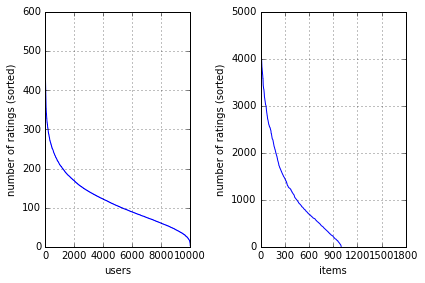

min # of items per user = 3, min # of users per item = 8.


In [36]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [37]:
from helpers import split_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1058987
Total number of nonzero elements in test data:117965


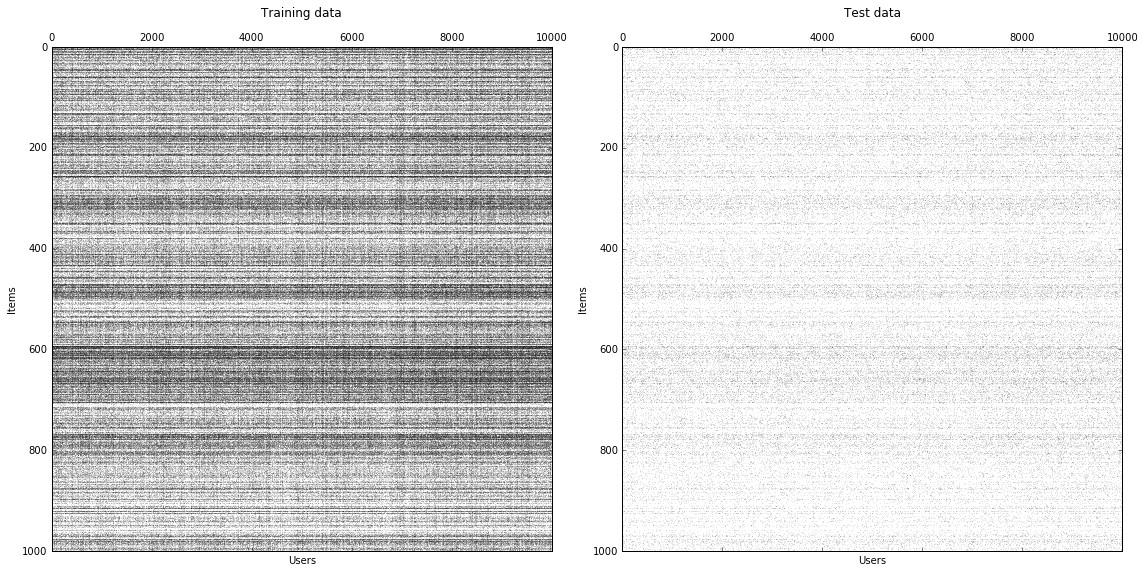

In [38]:
from plots import plot_train_test_data

plot_train_test_data(train, test)

# Data analysis

We want to analyse our data in order to have as much info as possible before starting to treat it.

For this puropose, we import the dataset as a Pandas DataFrame, which is very convenient to run various analysis.

In [39]:
from helpers import loadDataFrame
path_dataset = "data/data_train.csv"
data = loadDataFrame(path_dataset)

In [40]:
data.head()

,user,item,rating
0,44,1,4.0
1,61,1,3.0
2,67,1,4.0
3,72,1,3.0
4,86,1,5.0


## Ratings analysis

We can easily compute basic information about the ratings in our data.

We observe that we have an average of the rating of 3.857, with a standard deviation of 1.119.

In [41]:
data.rating.describe()

count    1.176952e+06
mean     3.857281e+00
std      1.119057e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

We also plot the distribution of the ratings. We observe that the most frequent ratings are 5-4-3 and we have only a few 2-1.

(1, 5)

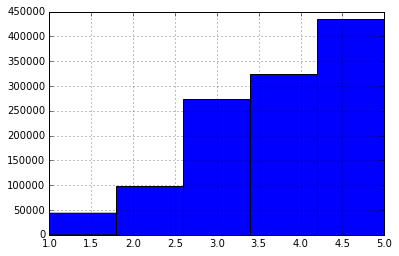

In [42]:
import matplotlib.pyplot as plt


ax = data["rating"].hist(bins = 5)
ax.set_xlim((1,5))

In [43]:
count = data.groupby("rating").count()["user"].reset_index()
count.columns = ["rating","count"]
count

,rating,count
0,1.0,43508
1,2.0,99180
2,3.0,274327
3,4.0,324700
4,5.0,435237


In [44]:
for rating in count.rating:
    rate = float(count[count["rating"] == rating]["count"] / count["count"].sum() * 100)
    print("Rating 1 : ", rate, "%")

Rating 1 :  3.6966673237311296 %
Rating 1 :  8.426851732271155 %
Rating 1 :  23.308257261128745 %
Rating 1 :  27.58821090409804 %
Rating 1 :  36.98001277877093 %


## User ratings

We now focus on the user to evaluate their ratings. We group the data by users and compute the average number of ratings they have and the standard deviation. 

We observe that a user rates 117.7 items on average, but with a standard deviation of 67.9.

In [45]:
user_ratings = data.groupby("user").count()["item"].to_frame()
user_ratings.columns = ["nb ratings"]
user_ratings.describe()

,nb ratings
count,10000.000000
mean,117.695200
std,67.900609
min,3.000000
25%,68.000000
50%,104.000000
75%,153.000000
max,522.000000


We now compute the average ratings given by each user and keep them in a dataframe

In [46]:
mean_user = data.groupby("user")["rating"].mean().to_frame()
mean_user.head()

,rating
user,
1,4.043478
2,3.771812
3,3.523256
4,3.800000
5,3.985075


We now want to know the standard deviation between the ratings of each user. This will gives us the info if a user gives different ratings to items or if he tends to give them the same ratings.

We observe the user have a average standard deviation of 1.065 in their ratings.

In [47]:
std_user = data.groupby("user")["rating"].std().to_frame()
std_user.describe()

,rating
count,10000.000000
mean,1.065531
std,0.149794
min,0.378535
25%,0.964366
50%,1.061773
75%,1.158456
max,1.786474


We now create a dataframe that contains all infos of users, the average ratings, the standard deviation of their rating and the number of rating.

In [48]:
user_grouped = data.copy()
user_grouped["nb rating"] =  user_grouped.groupby(["user"])['rating'].transform('count')
user_grouped = user_grouped.sort_values(["user"])
user_grouped = user_grouped.groupby("user").agg({'rating' : [np.mean, np.std], 'nb rating' : np.mean})[["rating","nb rating"]].reset_index()
user_grouped.columns = ["user", "rating mean", "rating std", "nb rating"]
user_grouped.head()

,user,rating mean,rating std,nb rating
0,1,4.043478,1.065076,23
1,2,3.771812,1.180476,149
2,3,3.523256,1.185468,86
3,4,3.800000,1.239694,20
4,5,3.985075,1.054778,134


We know plot the distribution of all these parameters

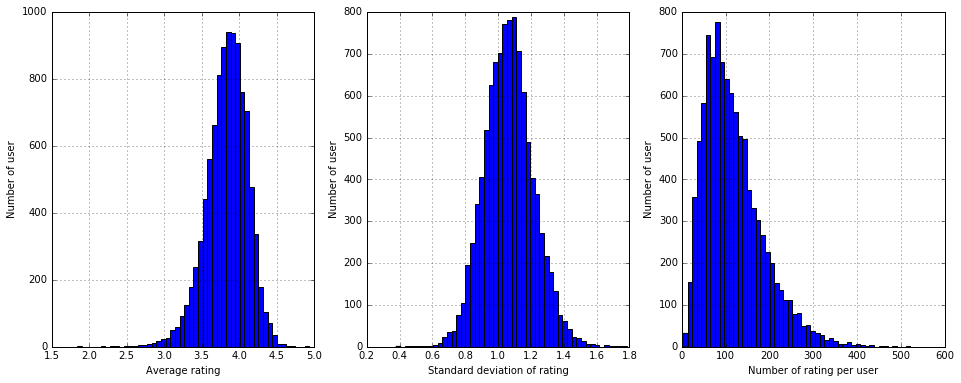

In [49]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 3, 1)
user_grouped["rating mean"].hist(ax = ax1, bins=50)
ax1.set_xlabel("Average rating")
ax1.set_ylabel("Number of user")
ax2 = fig.add_subplot(1, 3, 2)
user_grouped["rating std"].hist(ax = ax2, bins=50)
ax2.set_xlabel("Standard deviation of rating")
ax2.set_ylabel("Number of user")
ax3 = fig.add_subplot(1, 3, 3)
user_grouped["nb rating"].hist(ax = ax3, bins=50)
ax3.set_xlabel("Number of rating per user")
ax3.set_ylabel("Number of user")

We notice that the average rating and the standard deviation in ratings of the user follow nice gaussian distributions. 

This is not the case with the number of items rated per user.

## Distribution of average rating compared to number of items rated

We're interested to see if a user tends to rate items differently according to the number of rating he has done. For this purpose, we display the average ratings and their standard deviation for each user, according to the number of item he has rated.

[0, 600, 0, 2]

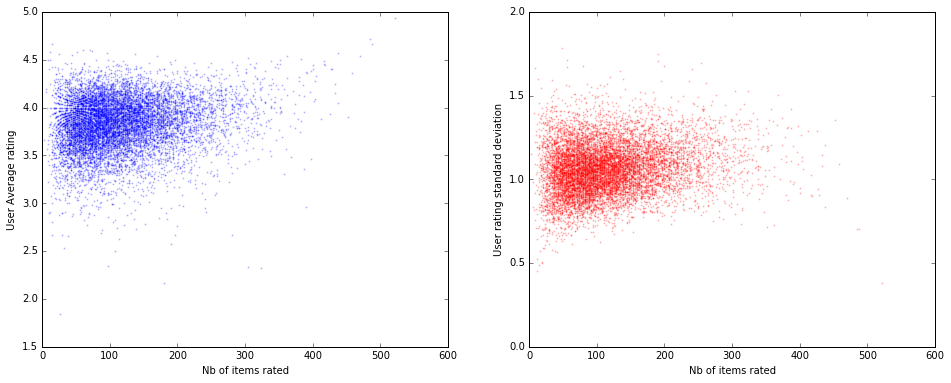

In [50]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(user_grouped["nb rating"], user_grouped["rating mean"], color='b', s=1, marker='o', alpha=.2)
ax1.set_xlabel("Nb of items rated")
ax1.set_ylabel("User Average rating")
ax1.axis([0, 600, 1.5, 5])
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(user_grouped["nb rating"], user_grouped["rating std"], color='r', s=1, marker='o', alpha=.2)
ax2.set_xlabel("Nb of items rated")
ax2.set_ylabel("User rating standard deviation")
ax2.axis([0, 600, 0, 2])

It seems that user with a lot of ratings tends to give better grades on average. To confirm it, we will now create groups of user and analyse their average ratings.

In [51]:
groups = groups = range(0,550,50)
ranges= []
ranges_average = []
means = []
nb = []
for i in range(1,len(groups)):
    ranges.append(str(groups[i-1])+"-"+str(groups[i]))
    ranges_average.append((groups[i-1]+groups[i])/2)
    group = user_grouped[(groups[i-1] <= user_grouped["nb rating"]) & (user_grouped["nb rating"] < groups[i])]
    nb.append(len(group))
    means.append(group["rating mean"].mean())
group_df = pd.DataFrame()
group_df["number of rating"] = ranges
group_df["nb ratings [center]"] = ranges_average
group_df["nb of users"] = nb
group_df["average rating"] = means
group_df

,number of rating,nb ratings [center],nb of users,average rating
0,0-50,25.0,1324,3.763685
1,50-100,75.0,3386,3.814643
2,100-150,125.0,2654,3.842488
3,150-200,175.0,1432,3.851901
4,200-250,225.0,706,3.871276
5,250-300,275.0,309,3.926242
6,300-350,325.0,126,3.982259
7,350-400,375.0,40,4.000424
8,400-450,425.0,17,4.272776
9,450-500,475.0,5,4.438000


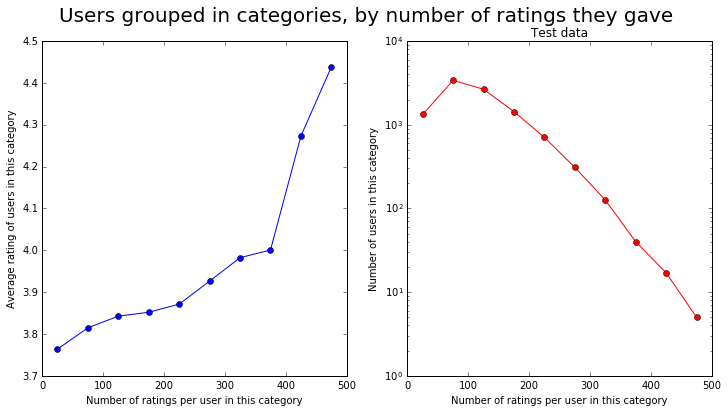

In [52]:
from plots import plot_average_rating_and_number_per_range

plot_average_rating_and_number_per_range(group_df, "average rating","nb of users","nb ratings [center]")

In [53]:
item_grouped = data.copy()
item_grouped["nb rating"] =  item_grouped.groupby(["item"])['rating'].transform('count')
item_grouped = item_grouped.sort_values(["item"])
item_grouped = item_grouped.groupby("item").agg({'rating' : [np.mean, np.std], 'nb rating' : np.mean})[["rating","nb rating"]].reset_index()
item_grouped.columns = ["item", "rating mean", "rating std", "nb rating"]
item_grouped.head()

,item,rating mean,rating std,nb rating
0,1,3.379412,1.061607,340
1,2,3.500942,1.030433,531
2,3,3.483586,1.073639,792
3,4,3.936473,1.180813,3164
4,5,3.559131,1.036532,1243


[0, 5000, 0.5, 2]

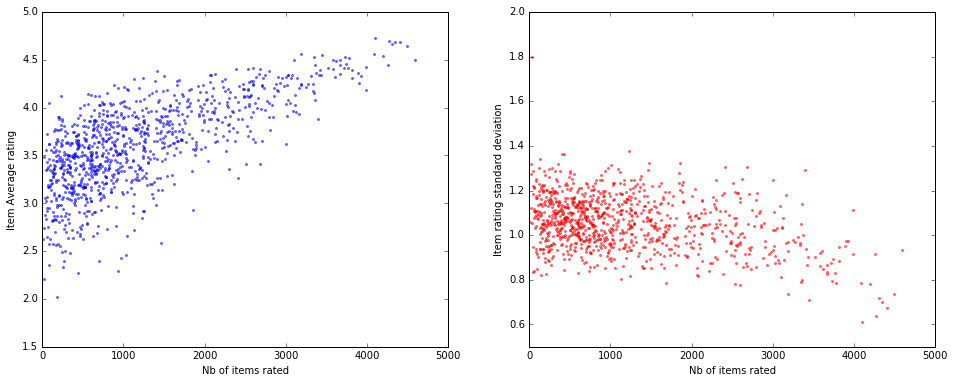

In [54]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(item_grouped["nb rating"], item_grouped["rating mean"], color='b', s=4, marker='o', alpha=.5)
ax1.set_xlabel("Nb of items rated")
ax1.set_ylabel("Item Average rating")
ax1.axis([0, 5000, 1.5, 5])
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(item_grouped["nb rating"], item_grouped["rating std"], color='r', s=4, marker='o', alpha=.5)
ax2.set_xlabel("Nb of items rated")
ax2.set_ylabel("Item rating standard deviation")
ax2.axis([0, 5000, 0.5, 2])

In [55]:
def predict_mf(data, user_features, item_features):
    product = item_features @ user_features.T
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = product[nz[0],nz[1]]
    return preds

In [56]:
def predict_mf_with_biaises(data, user_features, item_features, biaises):
    product = (item_features @ user_features.T) + biaises
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = product[nz[0],nz[1]]
    return preds

In [57]:
def predict_user(data, mean_user):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = mean_user[nz[1]+1]
    return preds

In [58]:
def predict_item(data, mean_item):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = mean_item[nz[0]+1]
    return preds

In [59]:
def compute_rmse(data, preds):
    nz_item, nz_user = data.nonzero()
    diff = 0
    for i in range(0, len(nz_item)):
        diff += np.square(data[nz_item[i], nz_user[i]] - preds[nz_item[i], nz_user[i]])
    rmse = np.sqrt(diff / len(nz_item))
    return rmse

In [60]:
mean_item = data.groupby("item").mean()["rating"]
mean_item.head()
preds_item = predict_item(valid_ratings, mean_item)
print(compute_rmse(valid_ratings, preds_item))

1.02942067458


In [61]:
mean_user = data.groupby("user").mean()["rating"]
mean_user.head()
preds_user = predict_user(valid_ratings, mean_user)
print(compute_rmse(valid_ratings, preds_user))

1.08502915952


In [29]:
#np.save("data/features/user_features.npy", user_features)
#np.save("data/features/item_features.npy", item_features)

In [30]:
#user_features = np.load("data/features/user_features.npy")
#item_features = np.load("data/features/item_features.npy")
#user_features = np.load("data/features/best2_user_features.npy")
#item_features = np.load("data/features/best2_item_features.npy")


In [31]:
#preds_mf = predict_mf(valid_ratings, user_features, item_features)
#rmse = compute_rmse(valid_ratings, preds_mf)
#rmse

In [64]:
user_features = np.load("data/features/melchior_user_features.npy")
item_features = np.load("data/features/melchior_item_features.npy")

In [73]:
from biaises import submission_biaises
mean = np.load("data/mean.npy")
item_means =  np.load("data/item_means.npy")
user_means =  np.load("data/user_means.npy")
valid_biais = submission_biaises(valid_ratings, mean, item_means, user_means)

In [74]:
preds_mf = predict_mf_with_biaises(valid_ratings, user_features, item_features, valid_biais)
rmse = compute_rmse(valid_ratings, preds_mf)
rmse

0.99441241126848323

In [75]:
nz_row, nz_col = preds_item.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_item[nz_row[i], nz_col[i]]])
df_item = pd.DataFrame(temp)
df_item.columns = ["Item", "User", "Item mean based prediction"]
df_item.head()

,Item,User,Item mean based prediction
0,0,43,3.379412
1,0,60,3.379412
2,0,66,3.379412
3,0,71,3.379412
4,0,85,3.379412


In [76]:
nz_row, nz_col = preds_user.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_user[nz_row[i], nz_col[i]]])
df_user = pd.DataFrame(temp)
df_user.columns = ["Item", "User", "User mean based prediction"]
df_user.head()

,Item,User,User mean based prediction
0,0,43,3.893701
1,0,60,4.233696
2,0,66,3.580645
3,0,71,3.861423
4,0,85,4.103321


In [77]:
nz_row, nz_col = preds_mf.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_mf[nz_row[i], nz_col[i]]])
df_mf = pd.DataFrame(temp)
df_mf.columns = ["Item", "User", "MF prediction"]
df_mf.head()

,Item,User,MF prediction
0,0,43,3.350800
1,0,60,3.871693
2,0,66,3.271014
3,0,71,3.204080
4,0,85,3.445172


In [78]:
nz_row, nz_col = valid_ratings.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], valid_ratings[nz_row[i], nz_col[i]]])
df_real = pd.DataFrame(temp)
df_real.columns = ["Item", "User", "Real values"]
df_real.head()

,Item,User,Real values
0,0,43,4.0
1,0,60,3.0
2,0,66,4.0
3,0,71,3.0
4,0,85,5.0


In [79]:
df_user_item = df_user[["Item", "User"]].copy()
df_user_item["User/Item mean prediction"] = (df_user["User mean based prediction"] + 
                                            df_item["Item mean based prediction"])/2
df_user_item.head()

,Item,User,User/Item mean prediction
0,0,43,3.636556
1,0,60,3.806554
2,0,66,3.480028
3,0,71,3.620417
4,0,85,3.741366


In [80]:
df_all = df_real.copy()
df_all["item diff"] = np.square(df_real["Real values"] - df_item["Item mean based prediction"])
df_all["user diff"] = np.square(df_real["Real values"] - df_user["User mean based prediction"])
df_all["item/user diff"] = np.square(df_real["Real values"] - df_user_item["User/Item mean prediction"])
df_all["mf diff"] = np.square(df_real["Real values"] - df_mf["MF prediction"])
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490


In [81]:
mean_squared_diff = df_all[["item diff", "user diff", "item/user diff", "mf diff"]].mean()
print("RMSE for item mean based prediction:", np.sqrt(mean_squared_diff["item diff"]))
print("RMSE for user mean based prediction:", np.sqrt(mean_squared_diff["user diff"]))
print("RMSE for item/user mean based prediction:", np.sqrt(mean_squared_diff["item/user diff"]))
print("RMSE for MF prediction:", np.sqrt(mean_squared_diff["mf diff"]))

RMSE for item mean based prediction: 1.02942067458
RMSE for user mean based prediction: 1.08502915952
RMSE for item/user mean based prediction: 1.02620246057
RMSE for MF prediction: 0.994412411268


In [82]:
df_all["item nb rating"] =  df_all.groupby(["Item"])['Real values'].transform('count')
df_all["user nb rating"] =  df_all.groupby(["User"])['Real values'].transform('count')
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff,item nb rating,user nb rating
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460,340,254
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848,340,184
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420,340,62
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649,340,267
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490,340,271


In [83]:
groups = range(0,550,25)
ranges= []
ranges_average = []
rmse_item = []
rmse_user = []
rmse_item_user = []
rmse_mf = []
bests = []
nb = []
for i in range(1,len(groups)):
    ranges.append(str(groups[i-1])+"-"+str(groups[i]))
    ranges_average.append((groups[i-1]+groups[i])/2)
    group = df_all[(groups[i-1] <= df_all["user nb rating"]) & (df_all["user nb rating"] < groups[i])]
    nb.append(len(group))
    item_mean = group["item diff"].mean()
    user_mean = group["user diff"].mean()
    mf_mean = group["mf diff"].mean()
    rmse_item.append(item_mean)
    rmse_user.append(user_mean)
    rmse_mf.append(mf_mean)
    best = "mf"
    if (item_mean < mf_mean): 
        best = "item"
    if ((user_mean < mf_mean) & (user_mean < item_mean)):
        best = "user"
    bests.append(best)
    
group_df = pd.DataFrame()
group_df["Category (#ratings/user)"] = ranges
group_df["center of category"] = ranges_average
group_df["nb of ratings in cat."] = nb
group_df["item based mean rmse"] = rmse_item
group_df["user based mean rmse"] = rmse_user
group_df["mf rmse"] = rmse_mf
group_df["best"] = bests
group_df.ix[:, group_df.columns != "center of category"]

,Category (#ratings/user),nb of ratings in cat.,item based mean rmse,user based mean rmse,mf rmse,best
0,0-25,3810,1.125788,1.045743,1.000589,mf
1,25-50,42937,1.083012,1.077066,0.987221,mf
2,50-75,104120,1.050980,1.095161,0.977720,mf
3,75-100,149246,1.023160,1.106520,0.958167,mf
4,100-125,162143,1.027240,1.146809,0.969033,mf
5,125-150,164038,1.012265,1.154480,0.958211,mf
6,150-175,131927,1.017894,1.183330,0.967686,mf
7,175-200,114121,1.059834,1.223254,1.002999,mf
8,200-225,89623,1.056005,1.223966,0.996852,mf
9,225-250,66394,1.103953,1.283230,1.040287,mf


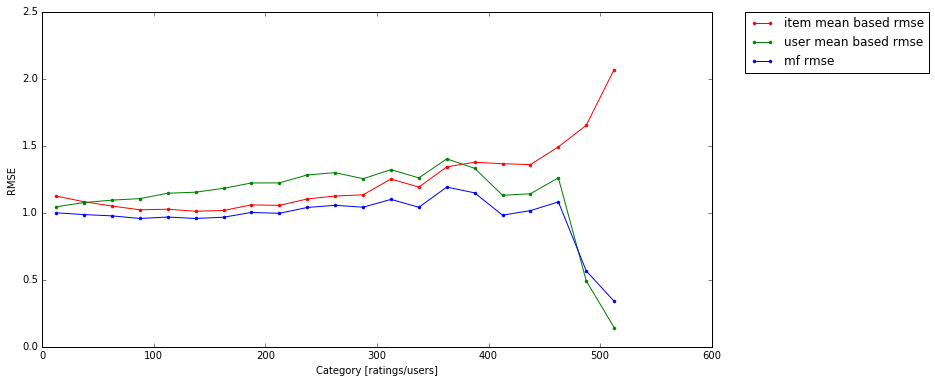

In [84]:
from plots import plot_rmse_per_categories

plot_rmse_per_categories(group_df, "center of category","item based mean rmse","user based mean rmse","mf rmse","Category [ratings/users]")

In [85]:
groups = [0,10,20,30,40,50,75,100,150]
for i in range(200, 4950, 250):
    groups.append(i)
print(groups)
ranges= []
ranges_average = []
rmse_item = []
rmse_user = []
rmse_item_user = []
rmse_mf = []
bests = []
nb = []
for i in range(1,len(groups)):
    ranges.append(str(groups[i-1])+"-"+str(groups[i]))
    ranges_average.append((groups[i-1]+groups[i])/2)
    group = df_all[(groups[i-1] <= df_all["item nb rating"]) & (df_all["item nb rating"] < groups[i])]
    nb.append(len(group))
    item_mean = group["item diff"].mean()
    user_mean = group["user diff"].mean()
    mf_mean = group["mf diff"].mean()
    rmse_item.append(item_mean)
    rmse_user.append(user_mean)
    rmse_mf.append(mf_mean)
    best = "mf"
    if (item_mean < mf_mean): 
        best = "item"
    if ((user_mean < mf_mean) & (user_mean < item_mean)):
        best = "user"
    bests.append(best)
    
group_df = pd.DataFrame()
group_df["Category (#ratings/user)"] = ranges
group_df["center of category"] = ranges_average
group_df["nb of ratings in cat."] = nb
group_df["item based mean rmse"] = rmse_item
group_df["user based mean rmse"] = rmse_user
group_df["mf rmse"] = rmse_mf
group_df["best"] = bests
group_df.ix[:, group_df.columns != "center of category"]

[0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 450, 700, 950, 1200, 1450, 1700, 1950, 2200, 2450, 2700, 2950, 3200, 3450, 3700, 3950, 4200, 4450, 4700]


,Category (#ratings/user),nb of ratings in cat.,item based mean rmse,user based mean rmse,mf rmse,best
0,0-10,8,0.984375,3.074152,8.304287,item
1,10-20,19,1.534626,4.042670,5.129436,item
2,20-30,54,1.443073,1.970865,3.791440,item
3,30-40,71,2.188872,2.793753,4.085047,item
4,40-50,180,1.123204,1.575799,1.873035,item
5,50-75,676,1.199114,1.598713,1.321125,item
6,75-100,955,1.164488,1.631893,1.178510,item
7,100-150,3562,1.188815,1.609444,1.099620,mf
8,150-200,5000,1.190714,1.636617,1.075640,mf
9,200-450,51514,1.176909,1.470861,1.077734,mf


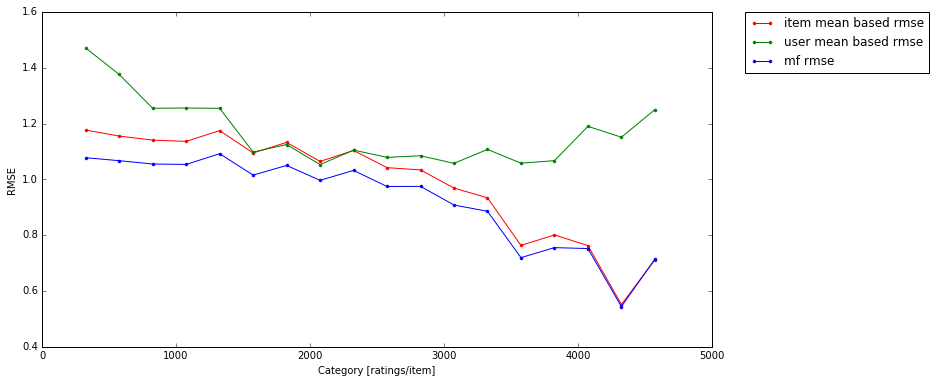

In [95]:
plot_rmse_per_categories(group_df[9:], "center of category","item based mean rmse","user based mean rmse","mf rmse","Category [ratings/item]")

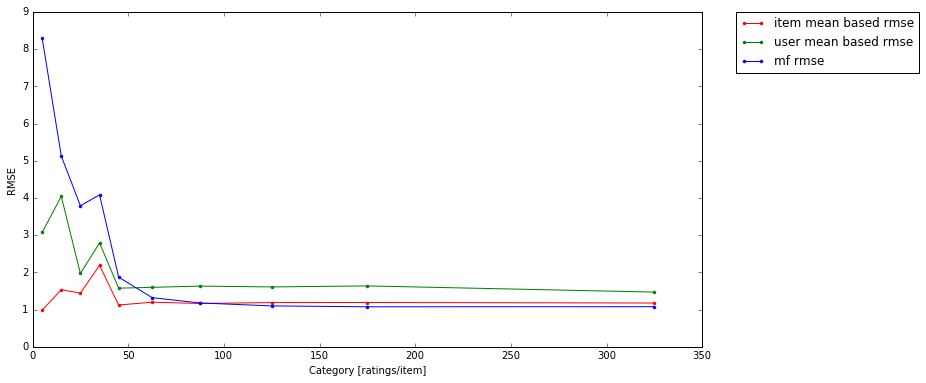

In [96]:
plot_rmse_per_categories(group_df[:10], "center of category","item based mean rmse","user based mean rmse","mf rmse","Category [ratings/item]")

In [97]:
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff,item nb rating,user nb rating,best predictions,best diff
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460,340,254,3.350800,0.421460
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848,340,184,3.871693,0.759848
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420,340,62,3.271014,0.531420
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649,340,267,3.204080,0.041649
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490,340,271,3.445172,2.417490


In [98]:
df_all["best predictions"] = df_mf["MF prediction"]
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff,item nb rating,user nb rating,best predictions,best diff
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460,340,254,3.350800,0.421460
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848,340,184,3.871693,0.759848
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420,340,62,3.271014,0.531420
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649,340,267,3.204080,0.041649
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490,340,271,3.445172,2.417490


In [99]:
user_best_index = (df_all["user nb rating"] > 475) | (df_all["user nb rating"] < 0)
df_all.loc[user_best_index,"best predictions"] = df_user[user_best_index]["User mean based prediction"]
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff,item nb rating,user nb rating,best predictions,best diff
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460,340,254,3.350800,0.421460
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848,340,184,3.871693,0.759848
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420,340,62,3.271014,0.531420
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649,340,267,3.204080,0.041649
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490,340,271,3.445172,2.417490


In [100]:
item_best_index = (df_all["item nb rating"] < 0) | (df_all["item nb rating"] > 4450)
df_all.loc[item_best_index,"best predictions"] = df_item[item_best_index]["Item mean based prediction"]
df_all.head()

,Item,User,Real values,item diff,user diff,item/user diff,mf diff,item nb rating,user nb rating,best predictions,best diff
0,0,43,4.0,0.385130,0.011300,0.132091,0.421460,340,254,3.350800,0.421460
1,0,60,3.0,0.143953,1.522005,0.650529,0.759848,340,184,3.871693,0.759848
2,0,66,4.0,0.385130,0.175858,0.270370,0.531420,340,62,3.271014,0.531420
3,0,71,3.0,0.143953,0.742050,0.384918,0.041649,340,267,3.204080,0.041649
4,0,85,5.0,2.626306,0.804033,1.584159,2.417490,340,271,3.445172,2.417490


In [101]:
df_all["best diff"] = np.square(df_all["Real values"]-df_all["best predictions"])

In [102]:
print("RMSE for best prediction:", np.sqrt(df_all["best diff"].mean()))

RMSE for best prediction: 0.994326737138


In [103]:
print("RMSE for best prediction:", np.sqrt(df_all["mf diff"].mean()))

RMSE for best prediction: 0.994412411268


# Result Generation

In [104]:
path_sample = "data/sampleSubmission.csv"
submission_sample = load_data(path_sample)

number of items: 1000, number of users: 10000


In [105]:
from biaises import submission_biaises
mean = np.load("data/mean.npy")
item_means =  np.load("data/item_means.npy")
user_means =  np.load("data/user_means.npy")
submission_biaises = submission_biaises(submission_sample, mean, item_means, user_means)
submission_preds_mf = predict_mf_with_biaises(submission_sample, user_features, item_features, submission_biaises)

In [106]:
#submission_preds_mf = predict_mf(submission_sample, user_features, item_features)

In [107]:
submission_preds_item = predict_item(submission_sample, mean_item)

In [108]:
submission_preds_user = predict_user(submission_sample, mean_user)

In [109]:
nz_row, nz_col = submission_preds_mf.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_mf[nz_row[i], nz_col[i]]])
submission_df_mf = pd.DataFrame(temp)
submission_df_mf.columns = ["Item", "User", "mf preds"]
submission_df_mf.head()

,Item,User,mf preds
0,0,36,3.247083
1,0,72,2.970193
2,0,155,3.859316
3,0,159,3.040773
4,0,247,3.207583


In [110]:
nz_row, nz_col = submission_preds_user.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_user[nz_row[i], nz_col[i]]])
submission_df_user = pd.DataFrame(temp)
submission_df_user.columns = ["Item", "User", "User prediction"]
submission_df_user.head()

,Item,User,User prediction
0,0,36,3.757732
1,0,72,3.540000
2,0,155,4.230216
3,0,159,3.692308
4,0,247,3.928144


In [111]:
nz_row, nz_col = submission_preds_item.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_item[nz_row[i], nz_col[i]]])
submission_df_item = pd.DataFrame(temp)
submission_df_item.columns = ["Item", "User", "Item prediction"]
submission_df_item.head()

,Item,User,Item prediction
0,0,36,3.379412
1,0,72,3.379412
2,0,155,3.379412
3,0,159,3.379412
4,0,247,3.379412


In [112]:
user_best_index = (df_all["user nb rating"] > 475) | (df_all["user nb rating"] < 0)
user_list = df_user[user_best_index]["User"].unique()
user_list

array([5511, 8705, 9710])

In [113]:
item_best_index = (df_all["item nb rating"] < 0) | (df_all["item nb rating"] > 4450)
item_list = df_item[item_best_index]["Item"].unique()
item_list

array([177, 607])

In [114]:
df_result = submission_df_mf.copy()
df_result.columns = ["Item","User","Best prediction"]
df_result.head()

,Item,User,Best prediction
0,0,36,3.247083
1,0,72,2.970193
2,0,155,3.859316
3,0,159,3.040773
4,0,247,3.207583


In [115]:
user_index = df_result["User"].isin(user_list)
df_result.loc[user_index,"Best prediction"] = submission_df_user[user_index]["User prediction"]
df_result.head()

,Item,User,Best prediction
0,0,36,3.247083
1,0,72,2.970193
2,0,155,3.859316
3,0,159,3.040773
4,0,247,3.207583


In [116]:
item_index = df_result["Item"].isin(item_list)
df_result.loc[item_index,"Best prediction"] = submission_df_item[item_index]["Item prediction"]
df_result.head()

,Item,User,Best prediction
0,0,36,3.247083
1,0,72,2.970193
2,0,155,3.859316
3,0,159,3.040773
4,0,247,3.207583


In [117]:
def to_result(data, result):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = result
    return preds

In [118]:
submission_preds = to_result(submission_sample, df_result["Best prediction"])

In [119]:
from helpers import write_data
path_submission = "data/biaisessubmission.csv"
write_data(path_submission, submission_preds)